# Assignment 8 Math Foundations Machine Learning
## David Alvear 187594

In [10]:
import numpy as np
import pandas as pd
import torch
import scipy
import scipy.linalg
from torch import nn
import seaborn as sns
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import multivariate_normal
from torch.utils.data import Dataset, random_split, DataLoader

## 1. Topic Classification
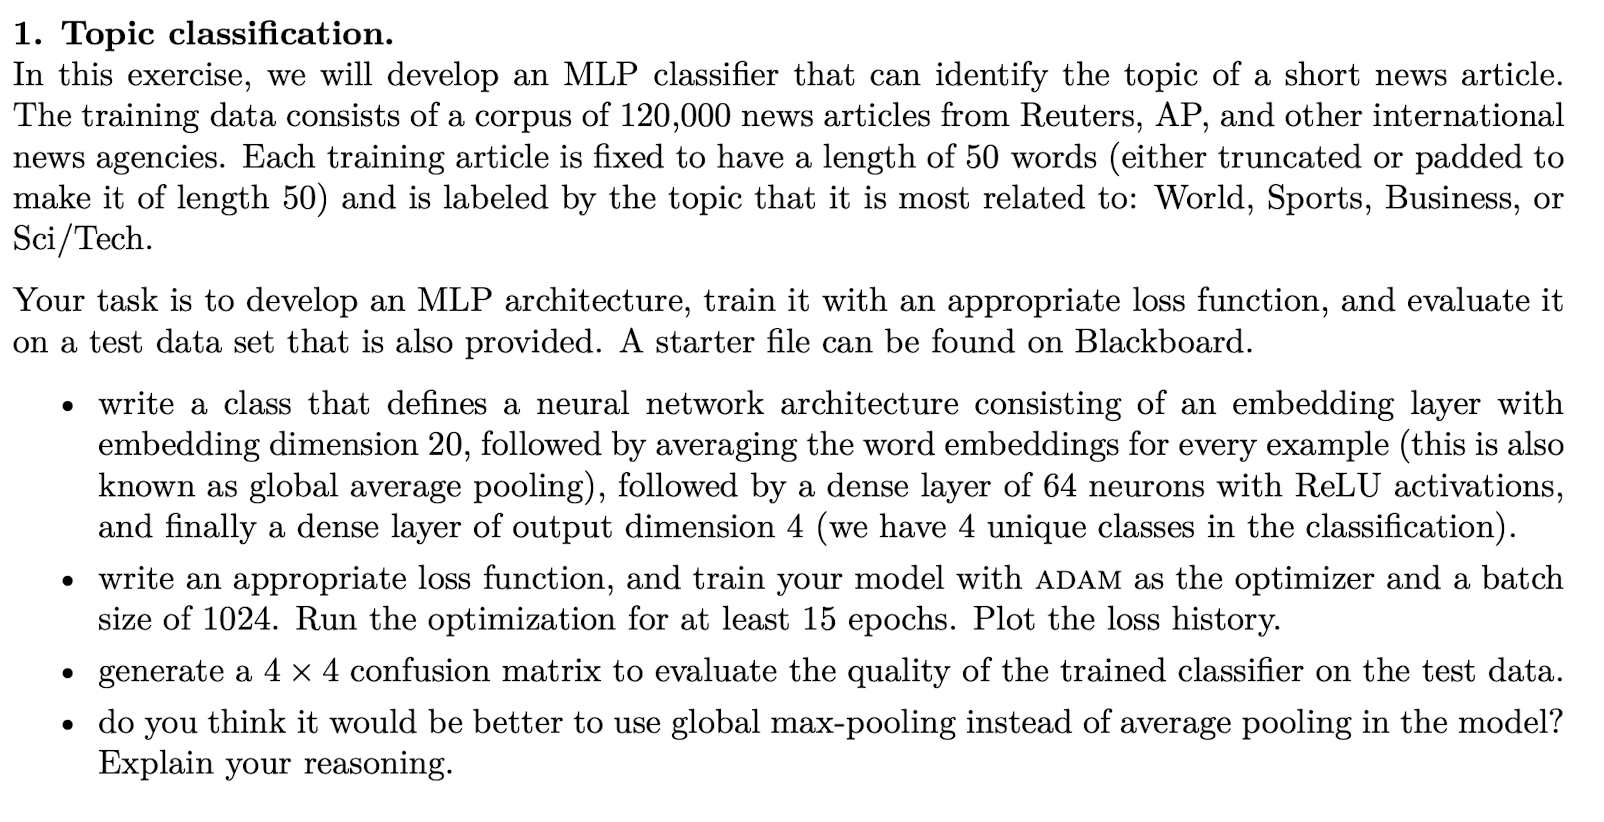

- **Goal**: Identify the topic of a short news article
- **training data**: 120.000
- **article**: 50 words
- **topics**: World, Sports, Business, Sci/Tech

1. Neural Network.
   - embedding layer of dim 20
   - averaging the word embeddings (gloval average pooling)
   - dense layer 64 neurons + ReLU activation
   - dense layer 4 neurons
2. Write loss function and train using **Adam**, **batch_size** 1024, **Epochs** 15
3. Generate confusion matrix
4. is it better to use global max-pooling instead of average pooling in the model?

In [2]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, TensorDataset, DataLoader
from collections import Counter
from torchinfo import summary

train_data = list(AG_NEWS(split='train'))
test_data  = list(AG_NEWS(split='test'))

# build a vocabulary---all words in training data
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for (label, line) in train_data:
    counter.update(tokenizer(line))
counter = dict(counter.most_common())    
vocab = torchtext.vocab.vocab(counter, min_freq=10, specials=('<PAD>', '<unk>'))
vocab.set_default_index(vocab['<unk>'])

# takes in a review (string), returns a vector of indices of length T
def text_transform(x, T=50):
    indices = [vocab[token] for token in tokenizer(x)]
    return indices[:T] if len(indices) > T else indices + [0] * (T-len(indices)) 

# raw labels are 1-4, ['World', 'Sports', 'Business', 'Sci/Tech']. Make them 0-3.
def label_transform(x):
    return x - 1

# returns X, y tensors from training data
def create_tensors(train_data):
    label_list, text_list = [], []
    for idx, (label, text) in enumerate(train_data):
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text))
        text_list.append(processed_text)
    return torch.stack(text_list), torch.tensor(label_list)

In [3]:
##########################################
######## Training Functions ##############
##########################################

def evaluate_model(model, dataloader):
    # Function that takes the model and evaluate in the test dataloader
    # return the predicted data for multi-class classification
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.tolist())
            all_targets.extend(targets.tolist())
            
    return all_predictions, all_targets

def one_epoch(model, dataloader, criterion, optimizer=None, training=True):
    """Perform one epoch"""
    total_loss = 0.0
    with torch.set_grad_enabled(training):
        model.train(training)
        for i, (input, targets) in enumerate(dataloader):
            prediction = model(input).squeeze()
            loss = criterion(prediction, targets)
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item()  # get the scalar value of the loss tensor
    return total_loss / len(dataloader)
    
def train(epochs, model, optimizer, criterion, train_dataloader, eval_dataloader):
    logs = []
    for epoch in range(epochs):
        # Run training 
        train_loss_epoch = one_epoch(
            model,
            train_dataloader,
            criterion,
            optimizer,
            True
        )

        # Run evaluation
        eval_loss_epoch = one_epoch(
            model,
            eval_dataloader,  # Corrected to eval_dataloader
            criterion,
            None,  # No optimizer for evaluation
            False
        )

        logs.append((train_loss_epoch, eval_loss_epoch))
        print(f"Epoch: {epoch}, Training Loss Avg: {train_loss_epoch:.4f}, Test Loss: {eval_loss_epoch:.4f}")
    return logs

##########################################
############## Plot semilog ##############
##########################################

def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(12, 6))
    plt.semilogy(train_loss, label='Training Loss')
    plt.semilogy(test_loss, label='Testing Loss')
    ymin, ymax = plt.ylim()  # Get current y-axis limits
    yticks = np.linspace(ymin, ymax, num=10)  # Create 10 equally spaced ticks
    plt.yticks(yticks)  # Set custom y-ticks
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

##########################################
######### Confussion Matrix ##############
##########################################

def visualize_confusion_matrix(test_labels, test_predicted_labels, labels=[1,0]):
    print("\nCONFUSSION MATRIX\n")
    conf_matrix = confusion_matrix(test_labels, test_predicted_labels)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def visualize_classification_report(test_labels, test_predicted_labels, labels=[1,0]):
    # Generate the test classification report
    print("\nCLASSIFICATION REPORT\n")
    report = classification_report(test_labels, test_predicted_labels, target_names=labels)
    print(report)

### Create dataloaders

In [15]:
X, y = create_tensors(train_data)
X_test, y_test = create_tensors(test_data)

# create dataloader. See https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
dataset = TensorDataset(X, y)
test_dataset = TensorDataset(X_test, y_test)
# Create dataloaders
train_dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

### Create model

In [43]:
class TextModel(nn.Module):
    def __init__(self, embed_dim, num_classes, vocab_size):
        super(TextModel, self).__init__()
        # Create embedding layer of size 20
        self.embed = nn.Embedding(vocab_size, embed_dim) # Embedding of size 20
        self.h = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(inplace=True),
        )
        self.dense = nn.Linear(64, num_classes) 
    def forward(self, x):
        rdim = 0 if x.ndim ==1 else 1
        x_embedded = self.embed(x)
        x_pooling = torch.mean(x_embedded, dim=rdim) # take the average of embedded vectors
        latent_x = self.h(x_pooling)
        latent_x = self.dense(latent_x)
        return latent_x

In [44]:
# Define the model
model = TextModel(20, 4, len(vocab))
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=10e-4)
# Criterion 
criterion = nn.CrossEntropyLoss()
# Training
logs = train(15, model, optimizer, criterion, train_dataloader, test_dataloader)

Epoch: 0, Training Loss Avg: 1.3187, Test Loss: 1.1571
Epoch: 1, Training Loss Avg: 0.8849, Test Loss: 0.6775
Epoch: 2, Training Loss Avg: 0.5631, Test Loss: 0.5092
Epoch: 3, Training Loss Avg: 0.4428, Test Loss: 0.4370
Epoch: 4, Training Loss Avg: 0.3829, Test Loss: 0.3927
Epoch: 5, Training Loss Avg: 0.3437, Test Loss: 0.3644
Epoch: 6, Training Loss Avg: 0.3155, Test Loss: 0.3474
Epoch: 7, Training Loss Avg: 0.2942, Test Loss: 0.3343
Epoch: 8, Training Loss Avg: 0.2765, Test Loss: 0.3167
Epoch: 9, Training Loss Avg: 0.2624, Test Loss: 0.3104
Epoch: 10, Training Loss Avg: 0.2490, Test Loss: 0.3041
Epoch: 11, Training Loss Avg: 0.2383, Test Loss: 0.2941
Epoch: 12, Training Loss Avg: 0.2273, Test Loss: 0.2927
Epoch: 13, Training Loss Avg: 0.2179, Test Loss: 0.2830
Epoch: 14, Training Loss Avg: 0.2095, Test Loss: 0.2871


### Test the model

In [45]:
loss_test = one_epoch(model, test_dataloader, criterion, optimizer, False)
print(f"Testing loss: {loss_test}")

Testing loss: 0.27894075959920883


### Results and comments

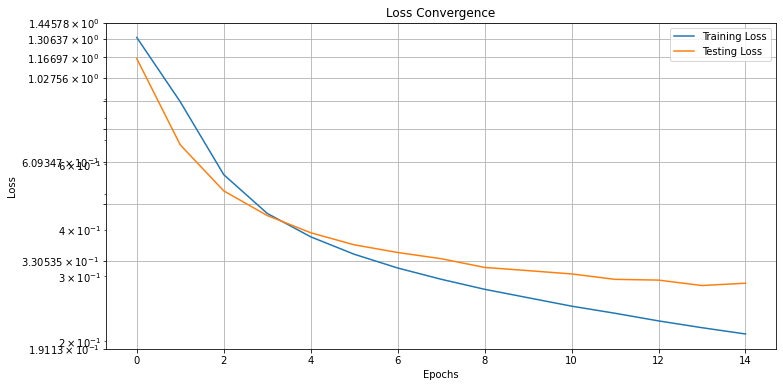

In [46]:
loss_values = np.array(logs)
plot_loss(loss_values[:,0], loss_values[:,1])


CONFUSSION MATRIX



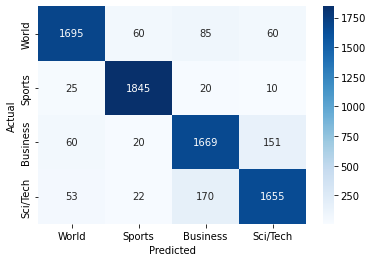


CLASSIFICATION REPORT

              precision    recall  f1-score   support

       World       0.92      0.89      0.91      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.86      0.88      0.87      1900
    Sci/Tech       0.88      0.87      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



In [47]:
test_pred, targets = evaluate_model(model, test_dataloader)
visualize_confusion_matrix(targets, test_pred, labels=['World','Sports', 'Business', 'Sci/Tech'])
visualize_classification_report(targets, test_pred, labels=['World','Sports', 'Business', 'Sci/Tech'])

### Create a model with max pooling 

In [48]:
class TextModelMax(nn.Module):
    def __init__(self, embed_dim, num_classes, vocab_size):
        super(TextModelMax, self).__init__()
        # Create embedding layer of size 20
        self.embed = nn.Embedding(vocab_size, embed_dim) # Embedding of size 20
        self.h = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(inplace=True),
        )
        self.dense = nn.Linear(64, num_classes) 
    def forward(self, x):
        rdim = 0 if x.ndim ==1 else 1
        x_embedded = self.embed(x)
        x_pooling, _ = torch.max(x_embedded, dim=rdim) # take the average of embedded vectors
        latent_x = self.h(x_pooling)
        latent_x = self.dense(latent_x)
        return latent_x

In [49]:
model_maxpooling = TextModelMax(20, 4, len(vocab))
# Define optimizer
optimizer = torch.optim.Adam(model_maxpooling.parameters(), lr=10e-4)
# Criterion 
criterion = nn.CrossEntropyLoss()
# Training
logs = train(15, model_maxpooling, optimizer, criterion, train_dataloader, test_dataloader)

Epoch: 0, Training Loss Avg: 1.3678, Test Loss: 1.3345
Epoch: 1, Training Loss Avg: 1.2657, Test Loss: 1.1878
Epoch: 2, Training Loss Avg: 1.0964, Test Loss: 1.0225
Epoch: 3, Training Loss Avg: 0.9401, Test Loss: 0.8872
Epoch: 4, Training Loss Avg: 0.8232, Test Loss: 0.7984
Epoch: 5, Training Loss Avg: 0.7353, Test Loss: 0.7286
Epoch: 6, Training Loss Avg: 0.6703, Test Loss: 0.6778
Epoch: 7, Training Loss Avg: 0.6220, Test Loss: 0.6357
Epoch: 8, Training Loss Avg: 0.5829, Test Loss: 0.6046
Epoch: 9, Training Loss Avg: 0.5505, Test Loss: 0.5783
Epoch: 10, Training Loss Avg: 0.5244, Test Loss: 0.5565
Epoch: 11, Training Loss Avg: 0.5019, Test Loss: 0.5421
Epoch: 12, Training Loss Avg: 0.4822, Test Loss: 0.5172
Epoch: 13, Training Loss Avg: 0.4661, Test Loss: 0.5095
Epoch: 14, Training Loss Avg: 0.4510, Test Loss: 0.5006


In [51]:
loss_test = one_epoch(model_maxpooling, test_dataloader, criterion, optimizer, False)
print(f"Testing loss: {loss_test}")

Testing loss: 0.4964756481349468



CONFUSSION MATRIX



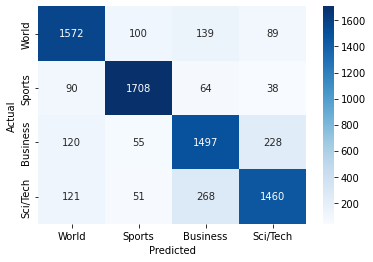


CLASSIFICATION REPORT

              precision    recall  f1-score   support

       World       0.83      0.83      0.83      1900
      Sports       0.89      0.90      0.90      1900
    Business       0.76      0.79      0.77      1900
    Sci/Tech       0.80      0.77      0.79      1900

    accuracy                           0.82      7600
   macro avg       0.82      0.82      0.82      7600
weighted avg       0.82      0.82      0.82      7600



In [50]:
test_pred, targets = evaluate_model(model_maxpooling, test_dataloader)
visualize_confusion_matrix(targets, test_pred, labels=['World','Sports', 'Business', 'Sci/Tech'])
visualize_classification_report(targets, test_pred, labels=['World','Sports', 'Business', 'Sci/Tech'])

### Conclusions
- Using average pooling results in better performance 0.90 in accuracy compared with 0.82 using max pooling.
- Average poolin computes the embedded vector averaging the vectors, and the max pooling get the maximum values of the embeddings of the words. Max pooling can capture words that are dominant for the topic. The average representation can capture the average representation of the article.
- Given that we are predicting the topic of the article, the results indicate that the average representation in the embedding layer results in better performance than using max pooling, this could be due that the average representation condense the all the words in an average representation of the article. The max pooling trigger the words that are dominant in the article.

## 2. CNN for MNIST data
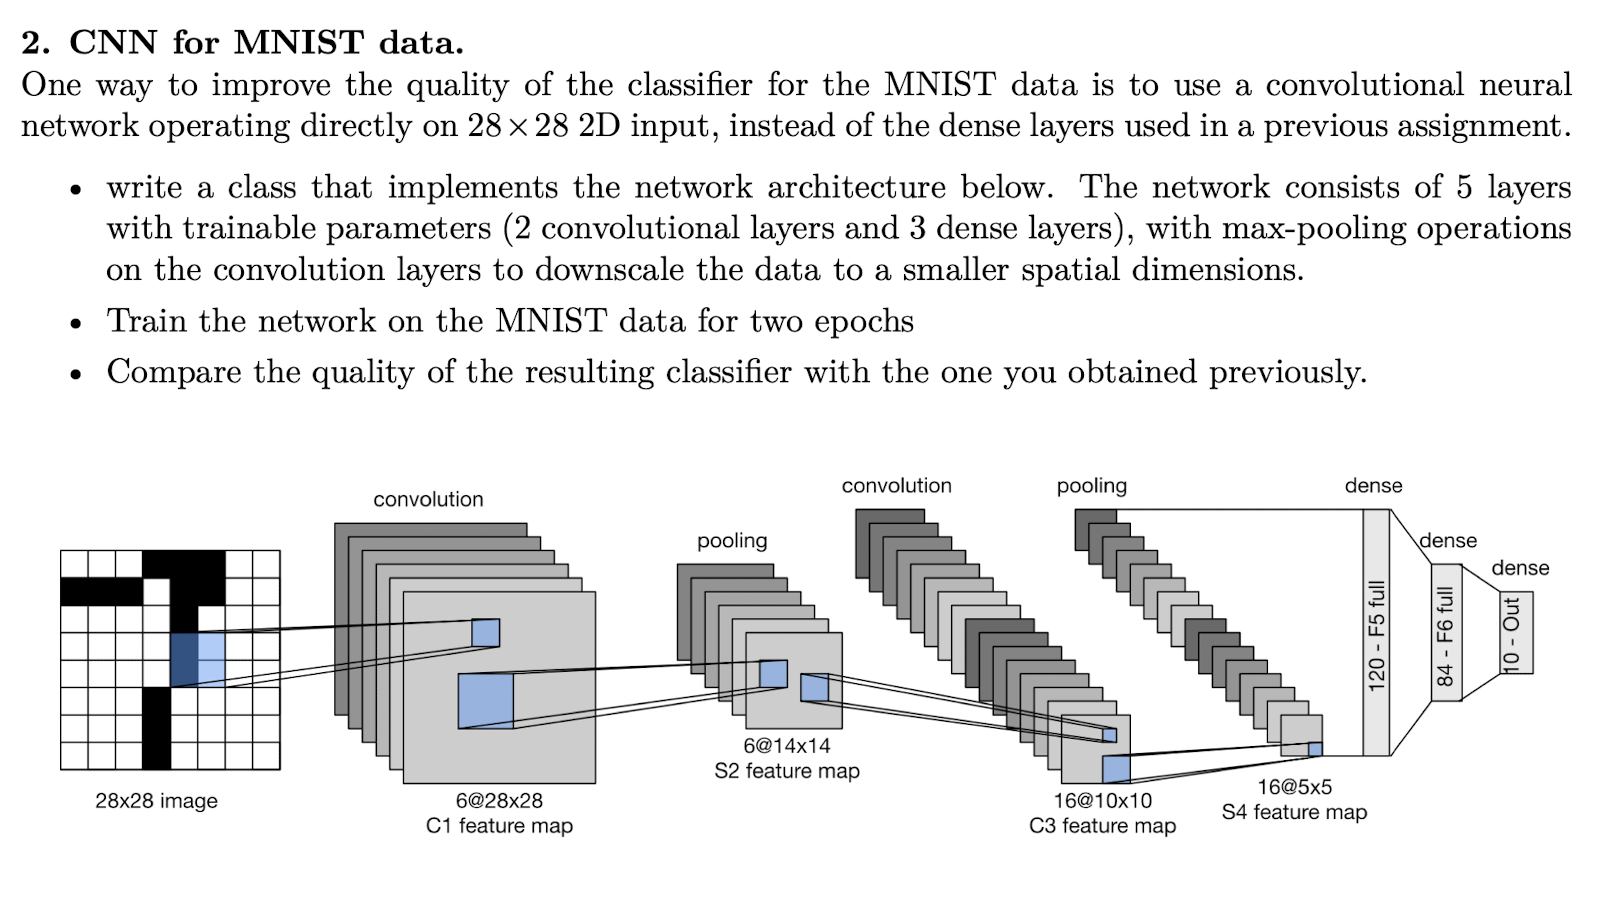

### Model
- Convolution 1
- Max-Pooling
- Convolution 2
- Max-Pooling
- Linear 120
- Linear 84
- Linear 10

In [4]:
class CNNModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=2, stride=1, padding=1), # 28x28
            nn.MaxPool2d(kernel_size=2, stride=2), #14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), # 10x10
            nn.MaxPool2d(kernel_size=2, stride=2), #5x5
            nn.ReLU(inplace=True), 
            nn.Flatten(),
            nn.Linear(400, 120), #120
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, out_channels),
        )

    def forward(self, x):
        return self.net(x)

### Load the MNIST data

In [7]:
# read MNIST training data
df = pd.read_csv('../data/mnist_train.csv')
df_test = pd.read_csv('../data/mnist_test.csv')
X = df.iloc[:, 1:].to_numpy() / 255.0   
X_test = df_test.iloc[:, 1:].to_numpy() / 255.0   # values are scaled to be between 0 and 1
y = df.iloc[:, 0].to_numpy()
y_test = df_test.iloc[:, 0].to_numpy() # labels of images

# Give format
X = torch.tensor(X.reshape(-1, 1, 28, 28), dtype=torch.float32)
X_test = torch.tensor(X_test.reshape(-1, 1, 28, 28), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create Datasets and Dataloaders
batch_size = 32
train_dataset = TensorDataset(X, y)
test_dataset = TensorDataset(X_test, y_test)
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Create model and train

In [17]:
# Define the model
model_cnn = CNNModel(1, 10)

In [18]:
# Define optimizer
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=10e-4)
# Criterion 
criterion = nn.CrossEntropyLoss()
# Training
logs = train(2, model_cnn, optimizer, criterion, train_dataloader, test_dataloader)

Epoch: 0, Training Loss Avg: 0.2582, Test Loss: 0.0740
Epoch: 1, Training Loss Avg: 0.0750, Test Loss: 0.0601


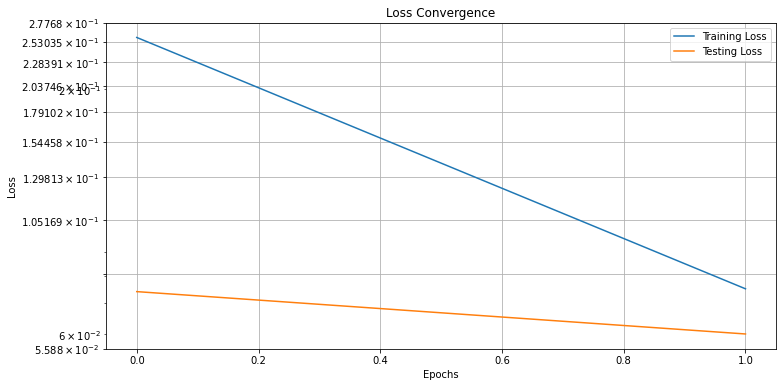

In [19]:
loss_values = np.array(logs)
plot_loss(loss_values[:,0], loss_values[:,1])


CONFUSSION MATRIX



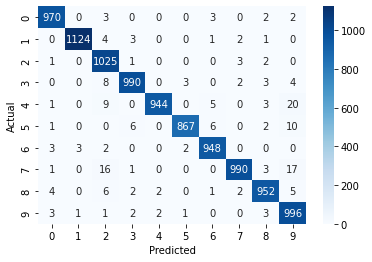


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.99      0.98      0.98      1010
           4       1.00      0.96      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.99       958
           7       0.99      0.96      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.94      0.99      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [22]:
test_pred, targets = evaluate_model(model_cnn, test_dataloader)
visualize_confusion_matrix(targets, test_pred, labels=["0","1","2","3","4","5","6","7","8","9"])
visualize_classification_report(targets, test_pred, labels=["0","1","2","3","4","5","6","7","8","9"])

### Comments
- Compared with previous assignment where we used only fully connected layers to classify the data, the performance and training time of the model using convolutional neural networks is better. Less time to achieve a good performance in the evaluation and also with only two epochs and a batch size of 32 with a learining rate of 10^-4 we have good classification performance.